# Differencing Stationarity

## Overview

<style>
    table.custom-table {
        max-width: 1000px;
        width: 100%;
        margin: 0 auto; /* centers the table on the page */
    }

    table.custom-table td {
        background-color: #fff;
    }
    
    table.custom-table th, table.custom-table td {
        text-align: center;
        vertical-align: middle;
        padding: 5px;
        width: 500px; /* distribute the total width equally among three columns */
    }

    table.custom-table img {
        width: 100%;
        display: block; /* removes any gap under the image */
    }
</style>


<table class="custom-table">
    <thead>
        <tr>
            <th>Output: Trend</th>
            <th>Input: Original Time Series</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>
                <img src="src/02_output_2.png">
            </td>
            <td>
                <img src="src/02_output_1.png">
            </td>
        </tr>
    </tbody>
</table>

In time series analysis, understanding stationarity and seasonality is crucial as they are key characteristics of time series data. This overview discusses their definitions, importance, and methods for testing and achieving stationarity, along with handling seasonality.

### **1. Stationarity**

- **Definition**: A time series is stationary if its statistical properties like mean, variance, and autocorrelation are constant over time. It shows no trend or seasonal effects, and fluctuations around its mean are consistent.
- **Importance**: Stationarity is a prerequisite for many time series models. Non-stationary data can yield unreliable results.
- **Testing**: Use tests like the Augmented Dickey-Fuller (ADF) or Kwiatkowski-Phillips-Schmidt-Shin (KPSS) to check stationarity.
- **Achieving Stationarity**: Techniques include differencing, log transformation, or a combination of these methods.

### **2. Seasonality**

- **Definition**: Seasonality implies regular, periodic fluctuations at set intervals, like daily, monthly, or yearly patterns.
- **Importance**: Accurate forecasting requires recognizing and adjusting for seasonality.
- **Detecting**: Visualization or decomposition methods like STL can help identify seasonal patterns.
- **Handling**: Methods vary, but seasonal differencing and models like SARIMA or Facebook's Prophet are effective.


### Summary:

- Stationarity addresses constant statistical properties over time.
- Seasonality involves predictable, recurring patterns.



A time series can exhibit both non-stationarity and seasonality, necessitating handling both for accurate forecasting.

#### Stationarity and Differencing:

Differencing is used to achieve stationarity in non-stationary data due to trends.
The 'I' in ARIMA indicates the differencing order needed for stationarity.

#### Seasonality and SARIMA:

SARIMA is suitable for data with seasonality, incorporating additional seasonal parameters.

The 'D' in SARIMA's seasonal parameters indicates the seasonal differencing order.

#### Modelling Choices:

- No Trend or Seasonality: Use basic ARIMA (d=0).
- Trend, No Seasonality: Use ARIMA with differencing.
- Seasonality (with/without Trend): Use SARIMA.

Model choice should be guided by data inspection, statistical tests, and tools like ACF and PACF plots.

## Data

In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss

df = pd.read_csv('../data/solar-generation.csv', index_col=0)
df.columns = ['generation']
df.index = pd.to_datetime(df.index, utc=True)
df = df.tz_convert('Europe/Madrid')
df = df.resample('1h').sum()
df

,generation
datetime_utc,
2014-01-01 00:00:00+01:00,27.2
2014-01-01 01:00:00+01:00,26.6
...,...
2023-10-01 22:00:00+02:00,16.9
2023-10-01 23:00:00+02:00,7.5


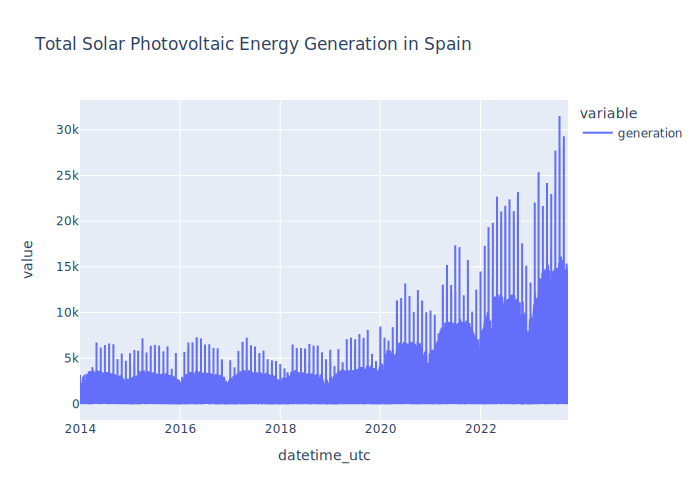

In [2]:
pd.options.plotting.backend = "plotly"
df.plot(title='Total Solar Photovoltaic Energy Generation in Spain')

## Testing for Stationarity: Raw Data
- **Augmented Dickey-Fuller (ADF) Test**: Tests for trend stationarity. Null hypothesis: the series is non-stationary.
- **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test**: Tests for level stationarity. Null hypothesis: the series is stationary.

Use both tests for a comprehensive assessment. The results guide the stationarity assumption and inform whether differencing or detrending is needed.

### ADF Test

In [3]:
result_adf = adfuller(df['generation'])
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])

ADF Statistic: -6.788588142370773
p-value: 2.3967151463086222e-09


### KPSS Test

In [4]:
result_kpss = kpss(df['generation'], nlags="auto")
print('\nKPSS Statistic:', result_kpss[0])
print('p-value:', result_kpss[1])


KPSS Statistic: 72.87924726680099
p-value: 0.01


/var/folders/89/hqh4vvhn24q2xc8ph93krqz80000gn/T/ipykernel_34616/1515744726.py:1: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




## Differencing for Stationarity
Apply differencing to the dataset and retest for stationarity using ADF and KPSS tests.

In [5]:
# Differencing
df['diff_stationarity'] = df['generation'].diff().dropna()
df

,generation,diff_stationarity
datetime_utc,,
2014-01-01 00:00:00+01:00,27.2,NaN
2014-01-01 01:00:00+01:00,26.6,-0.6
...,...,...
2023-10-01 22:00:00+02:00,16.9,-0.9
2023-10-01 23:00:00+02:00,7.5,-9.4


In [6]:
dff = df.rename(columns={'generation': 'generation (Original)', 'diff_stationarity': 'Diff Stationarity'})
dff

,generation (Original),Diff Stationarity
datetime_utc,,
2014-01-01 00:00:00+01:00,27.2,NaN
2014-01-01 01:00:00+01:00,26.6,-0.6
...,...,...
2023-10-01 22:00:00+02:00,16.9,-0.9
2023-10-01 23:00:00+02:00,7.5,-9.4


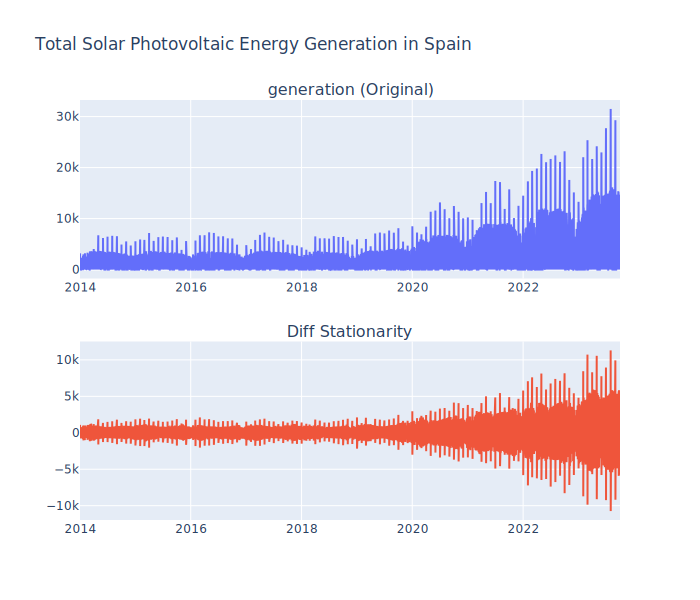

In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1, vertical_spacing=0.15, subplot_titles=dff.columns)

for idx, column in enumerate(dff.columns, 1):
    fig.add_trace(go
        .Scatter(
            x=dff.index, y=dff[column].values, name=column,),
            row=idx, col=1)

fig.update_layout(
    showlegend=False, height=600,
    title='Total Solar Photovoltaic Energy Generation in Spain')

fig.show()

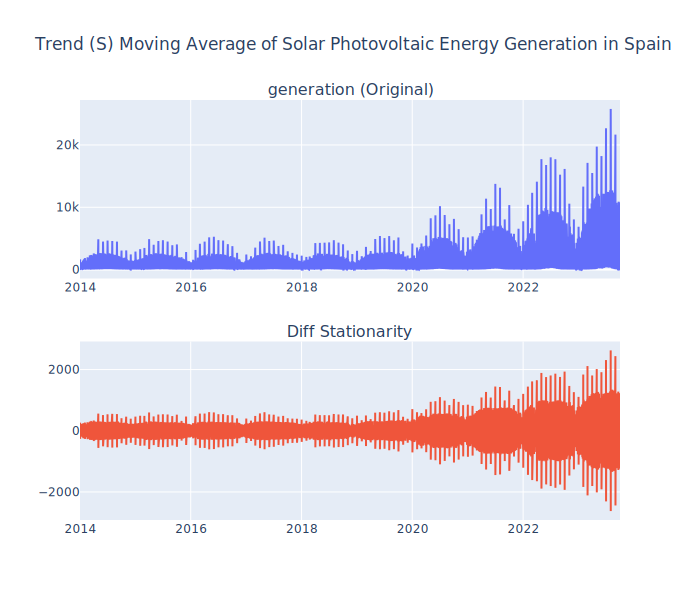

In [8]:
dff = df.rolling(window=12).mean().rename(columns={'generation': 'generation (Original)', 'diff_stationarity': 'Diff Stationarity'})

fig = make_subplots(rows=2, cols=1, vertical_spacing=0.15, subplot_titles=dff.columns)

for idx, column in enumerate(dff.columns, 1):
    fig.add_trace(go
        .Scatter(
            x=dff.index, y=dff[column].values, name=column,),
            row=idx, col=1)

fig.update_layout(
    height=600, showlegend=False,
    title='Trend (S) Moving Average of Solar Photovoltaic Energy Generation in Spain')

fig.show()

## ADF and KPSS Test Implementation

### ADF Test

In [9]:
result_adf = adfuller(df['diff_stationarity'].dropna())
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])

ADF Statistic: -61.545294336443014
p-value: 0.0


### KPSS Test

In [10]:
result_kpss = kpss(df['diff_stationarity'].dropna())
print('\nKPSS Statistic:', result_kpss[0])
print('p-value:', result_kpss[1])


KPSS Statistic: 0.009337862394511147
p-value: 0.1


/var/folders/89/hqh4vvhn24q2xc8ph93krqz80000gn/T/ipykernel_34616/3680348055.py:1: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




## Seasonal Differencing
Seasonal differencing (e.g., over 12 periods) may be required for data with strong seasonal patterns. After differencing, reapply ADF and KPSS tests.

In [11]:
# Differencing
df['diff_seasonality_12'] = df['diff_stationarity'].diff(12).dropna()
df

,generation,diff_stationarity,diff_seasonality_12
datetime_utc,,,
2014-01-01 00:00:00+01:00,27.2,NaN,NaN
2014-01-01 01:00:00+01:00,26.6,-0.6,NaN
...,...,...,...
2023-10-01 22:00:00+02:00,16.9,-0.9,-5295.525
2023-10-01 23:00:00+02:00,7.5,-9.4,-1648.068


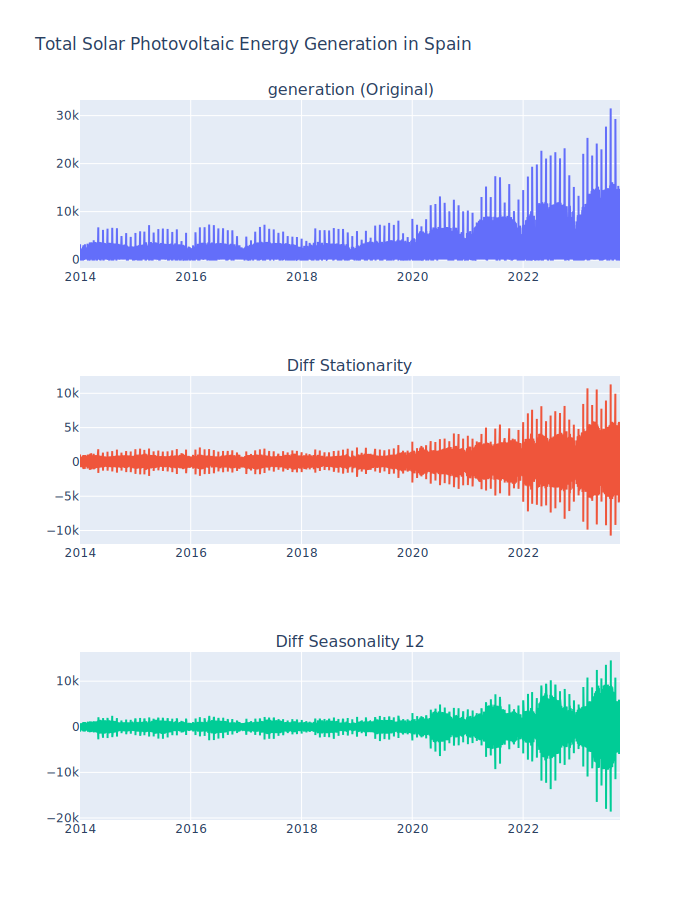

In [12]:
dff = df.rename(columns={'generation': 'generation (Original)', 'diff_stationarity': 'Diff Stationarity', 'diff_seasonality_12': 'Diff Seasonality 12'})

fig = make_subplots(rows=3, cols=1, vertical_spacing=0.15, subplot_titles=dff.columns)

for idx, column in enumerate(dff.columns, 1):
    fig.add_trace(go
        .Scatter(
            x=dff.index, y=dff[column].values, name=column,),
            row=idx, col=1)

fig.update_layout(
    height=900, showlegend=False,
    title='Total Solar Photovoltaic Energy Generation in Spain')

fig

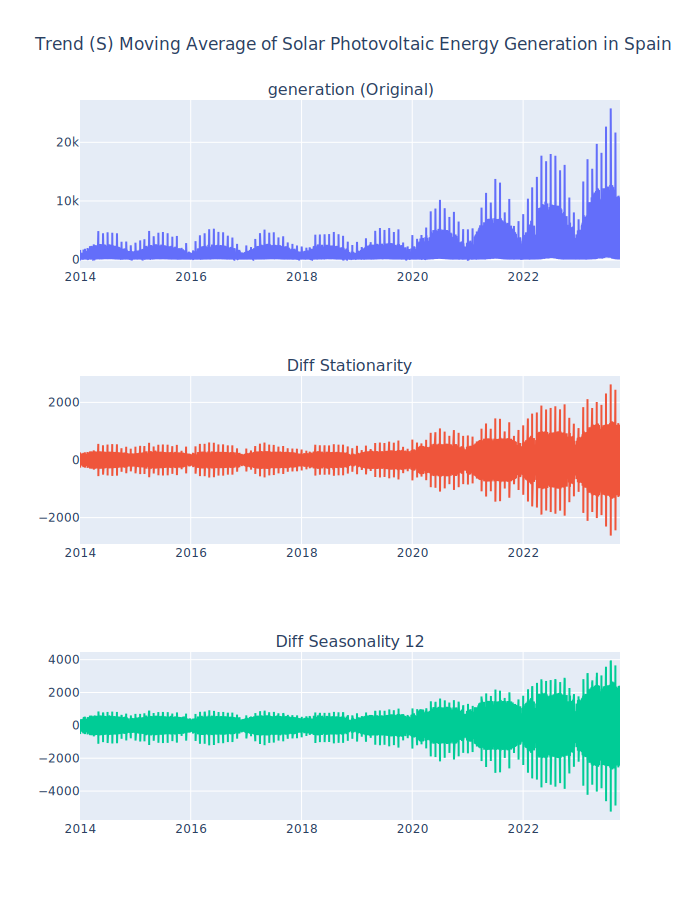

In [14]:
dff = df.rolling(window=12).mean().rename(columns={'generation': 'generation (Original)', 'diff_stationarity': 'Diff Stationarity', 'diff_seasonality_12': 'Diff Seasonality 12'})

fig = make_subplots(rows=3, cols=1, vertical_spacing=0.15, subplot_titles=dff.columns)

for idx, column in enumerate(dff.columns, 1):
    fig.add_trace(go
        .Scatter(
            x=dff.index, y=dff[column].values, name=column,),
            row=idx, col=1)

fig.update_layout(
    height=900, showlegend=False,
    title='Trend (S) Moving Average of Solar Photovoltaic Energy Generation in Spain')

fig

### ADF Test

In [16]:
result_adf = adfuller(df['diff_seasonality_12'].dropna())
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])

ADF Statistic: -71.77459982606274
p-value: 0.0


### KPSS Test

In [17]:
result_kpss = kpss(df['diff_seasonality_12'].dropna())
print('\nKPSS Statistic:', result_kpss[0])
print('p-value:', result_kpss[1])


KPSS Statistic: 0.008102591976852282
p-value: 0.1


/var/folders/89/hqh4vvhn24q2xc8ph93krqz80000gn/T/ipykernel_34616/1870162030.py:1: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


